# CLC – Machine Learning on a Microcontroller

## 1. Introduction & Objective
The goal for this assignment is to design and then train a machine learning model for computing a trigonometric function. The trigonometric function we decided to use is the sine function. After designing and training the model, we built the model and converted it into a .tflite model. We used a small Dense neural network as this works better for microcontrollers. Microcontrollers have less resources than a typical desktop which cause it to have limitations for machine learning. 

## 2. Data Preparation
We generated the training data for the model using numpy in units of radians. We then created a data frame and saved it as a .csv file. Shown below are the first entries in the dataset as well as a plot of the sine function.

In [ ]:
import numpy as np
import pandas as pd

# Generate input data RADIANS
x = np.linspace(0, 2 * np.pi, 1000)
y = np.sin(x)

# Create a DataFrame
data = pd.DataFrame({
    'x': x,
    'sin(x)': y
})

# Preview Data
data.head()


,x,sin(x)
0,0.000000,0.000000
1,0.006289,0.006289
2,0.012579,0.012579
3,0.018868,0.018867
4,0.025158,0.025155


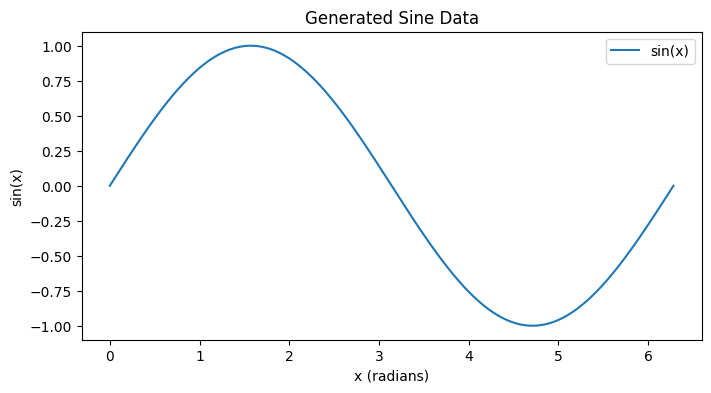

In [ ]:
import matplotlib.pyplot as plt

# Plot the sine function
plt.figure(figsize=(8,4))
plt.plot(x, y, label="sin(x)")
plt.xlabel("x (radians)")
plt.ylabel("sin(x)")
plt.title("Generated Sine Data")
plt.legend()
plt.show()

## 3. Model Design
The model we designed utilized the framework TensorFlow/Keras. The neural network consists of an input layer with 1 node and two hidden layers using Dense which each contain 8 neurons and is activated using the tanh function. Lastly, there is an output layer with 1 node that has linear activation.

The reason our model only contains 4 layers is that there is a lack of resources on a microcontroller which severely limits how many layers we can have. The model is meant to be efficient and small to ensure it is compatible with a microcontroller. 

In [ ]:
import tensorflow as tf

# Define the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,)),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(8, activation='tanh'),
    tf.keras.layers.Dense(1)
])

model.summary()

## 4. Training the Model
The model is compiled with a loss function and an optimizer. The loss function we chose is Mean Square Error which is common for trigonometric problems. The Adam optimizer was chosen for its learning rate.

We trained for 200 epochs to ensure that it was properly trained and validated. 

In [ ]:
X_train = data[['x']].values
Y_train = data[['sin(x)']].values

# Compile and train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, Y_train, epochs=200, verbose=0)

## 5. Evaluation
We computed two metrics to test the model's performance and accuracy:
- Mean Squared Error (MSE): This formula helps find where the model deviates from the true sine curve the most.
- Mean Absolute Error (MAE): This tells you the typical prediction accuracy by measuring the absolute difference of the errors from the true sine curve. 

In [ ]:
import os
import numpy as np
import tensorflow as tf

base_dir = os.path.dirname(__file__)
tflite_path = os.path.join(base_dir, "..", "Model", "sine_model.tflite")

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

x_test = np.linspace(0, 2 * np.pi, 100, dtype=np.float32)
y_true = np.sin(x_test)

y_pred = []

for val in x_test:
    input_data = np.array([[val]], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]
    y_pred.append(prediction)

y_pred = np.array(y_pred)

mse = np.mean((y_true - y_pred) ** 2)
mae = np.mean(np.abs(y_true - y_pred))

print("Model Evaluation Results:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")

for i in range(0, len(x_test), 20):
    print(f"x = {x_test[i]:.3f}, predicted = {y_pred[i]:.4f}, true = {y_true[i]:.4f}")


NameError: name '__file__' is not defined

## 6. Model Conversion to TensorFlow Lite

After training ur neural network model, we converted it to TensorFlow lite to ensure it is compatbile with microcontrollers as it is designed for devices with limited resources.

In [ ]:
import os
import tensorflow as tf

base_dir = os.path.dirname(__file__)
keras_path = os.path.join(base_dir, "sine_model.keras")
tflite_path = os.path.join(base_dir, "sine_model.tflite")

model = tf.keras.models.load_model(keras_path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print(f"Model converted and saved to {tflite_path}")


The conversion significiantly reduces the model size while still maintaining comptability with devices with limited resources.

## 7. Testing the TensorFlow Lite Model

To ensure that the model performs correctly, tests were created using the newly converted model with specific test values on the sine curve. This is important to ensure the conversion didnt degrate our model's

In [ ]:
import os
import numpy as np
import tensorflow as tf

base_dir = os.path.dirname(__file__)

tflite_path = os.path.join(base_dir, "..", "Model", "sine_model.tflite")

interpreter = tf.lite.Interpreter(model_path=tflite_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

test_values = np.array([0.0, np.pi/6, np.pi/4, np.pi/2, np.pi], dtype=np.float32)

print("Testing TFLite model:")
for val in test_values:
    input_data = np.array([[val]], dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()

    prediction = interpreter.get_tensor(output_details[0]['index'])[0][0]
    print(f"x = {val:.3f}, predicted sin(x) = {prediction:.4f}, true sin(x) = {np.sin(val):.4f}")


The testing focus on points 0, π/6, π/4, π/2, and π as they represent key positions on the sine curve. The test results also show how well the model approximates the sine function at these points.

## 8. Conclusion

This project demonstrated the implementation of a machine learning model for computing trigonometric functions on microcontrollers. The approach yieleded several achievements and insights such as:
- Model Performance: TWo hidden layers of 8 neurons each to use to approximate the sine function with high accuracy. 
- Microcontroller Optimization: The choice of a compact architecture provied to be used with microcontroller deployment.
- Conversion Success: The TensorFlow Lite conversion process maintained model accuracy while also providing a deployment ready format for embedded systems. The model showed minimal degradation which is helpful for real-world microcontroller applications.

Future improvements: Potential enhancements could be implementing quantization to reduce the model size even further, trying different activation functions, or testing more complex trigonometric functions. Actual deployment on a physical microcontroller would validate if the performance and resource utilization is seen.

The project demonstrates machine learning can be implemented onto microcontrollers for mathematical functions, opening the door for embedded AI applications in IoT devices and real-time control systems.

## 9. References
TensorFlow Lite Documentation

Keras Documentation
